In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

import itertools
from sklearn.metrics import accuracy_score

## Data Source and Project Summary

This project attempts the Kaggle BBC News Classification competition: https://www.kaggle.com/c/learn-ai-bbc/. The competition asks you to classify text articles into one of five categories -- business, entertainment, politics, sport, and tech -- and uses accuracy to compare submissions.

There are three datasets:
- Train (with labels)
- Test (without labels)
- Sample solution (sample labels for the test set -- this is what you submit for the Kaggle competition)

This project will approach the competition from a different angle, using unsupervised matrix factorization instead of supervised learning. We will then compare supervised learning approaches to see how performance differs across different models and modeling strategies.

I decided to go with a more complicated approach for me in using Word2Vec to create word embeddings, then create document embeddings based on the word embeddings, and then use singular value decomposition (SVD) for clustering. A simpler approach -- and possibly a better one -- would be to use a count-based approach instead of embeddings and then run matrix factorization on that count-based matrix. I wanted to tackle word embeddings to see if the added complexity and context provides better performance.

## Loading and Initial Analysis

In [2]:
df_train = pd.read_csv('./data/BBC News Train.csv')
df_test = pd.read_csv('./data/BBC News Test.csv')

print(f'The training set has {df_train.shape[0]:,} rows')
print(f'The test set has {df_test.shape[0]:,} rows')
df_train.head(10)

The training set has 1,490 rows
The test set has 735 rows


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


In [3]:
df_test.head(10)

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
5,51,lewsey puzzle over disallowed try england s jo...
6,2025,blair blasts tory spending plans tony blair ha...
7,1479,former ni minister scott dies former northern ...
8,27,career honour for actor dicaprio actor leonard...
9,397,tsunami to hit sri lanka banks sri lanka s b...


The `Text` feature looks like it includes both article headers and article bodies, based on a visual inspection of values in that column. We are going to model based on counts of words, so the awkward jump from header to body will not be a problem for our modeling.

In [4]:
df_train.isna().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

We do not have missing values that we need to handle. We will look further into the `Text` feature shortly to determine if we need to do further cleanup there.

In [5]:
print(f"The training set has {df_train['ArticleId'].nunique():,} unique ArticleId values")
print(f"The training set has {df_train['Text'].nunique():,} unique Text values but {df_train.shape[0]} total Text values")
print(f"The training set has {df_train[df_train.duplicated(['Text', 'Category'])].shape[0]:,} duplicate values across both Text and Category")

df_train.drop_duplicates(
    subset=[
        'Text'
        , 'Category'
    ], inplace=True
)

The training set has 1,490 unique ArticleId values
The training set has 1,440 unique Text values but 1490 total Text values
The training set has 50 duplicate values across both Text and Category


A companion check to missing values is duplicate values. The test set has 1,490 rows and the same number of unique `ArticleId` values, but it only has 1,440 unique `Text` values. We drop the 50 duplicate value across both `Text` and `Category` so the duplicate do not skew the modeling by overrepresenting those articles and their underlying trends.

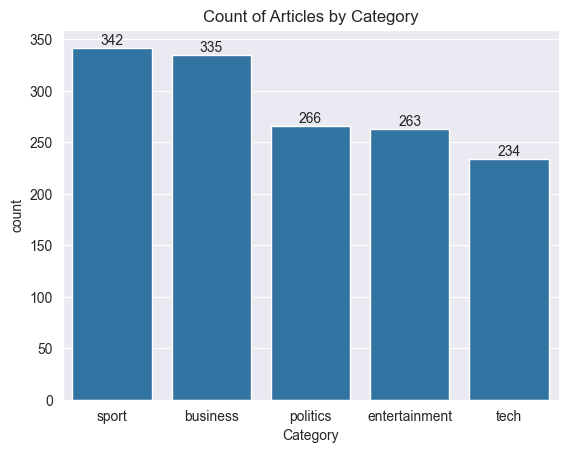

In [6]:
cp = sns.countplot(
    df_train
    , x='Category'
    , order=df_train['Category'].value_counts().index
)
cp.set_title('Count of Articles by Category')
cp.bar_label(cp.containers[0]); # Add counts on top of bars

Even though we are focusing on unsupervised learning, we can check to make sure the label distribution is not imbalanced enough to cause worries.

The plot shows a healthy balance among all five classes with the biggest imbalance reducing down to $\frac{342}{234} \equals \frac{19}{13}$ (not important, but these two values are anagrams). This should not cause a class imbalance issue for any of the algorithms we look at.

Before we tokenize the articles, we can do a preliminary look at the length of the articles.

count     1440.000000
mean      2234.261806
std       1211.698556
min        501.000000
25%       1451.250000
50%       1964.000000
75%       2754.000000
max      18387.000000
Name: Text, dtype: float64





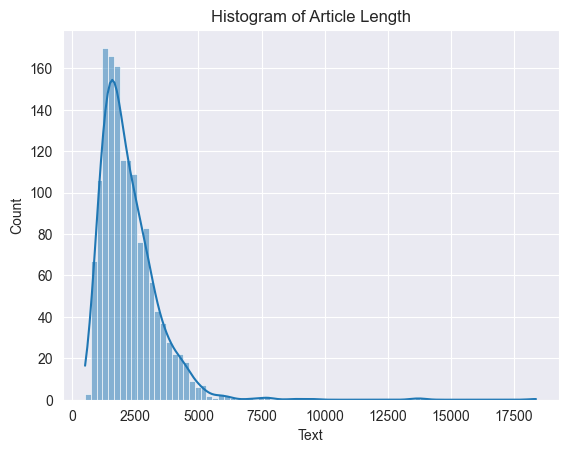

In [7]:
# Summary stats of article lengths
article_lengths = df_train['Text'].str.len()
print(article_lengths.describe())
print('\n\n')

# Univariate distribution of article lengths
sns.histplot(
    article_lengths
    , kde=True
).set_title('Histogram of Article Length');

75% of the articles have 2,754 words or less. There are some outliers on the higher end of word count that skew the distribution to the right. We may want to explore this more after having more detail about the text inside the articles. But, to get there, we need to dig into the content of the articles in a little bit.

We will visually inspect a few of the outliers in length to make sure they look normal enough that we do not need to preprocess them further.

In [8]:
df_train[(article_lengths < 800) | (article_lengths > 10000)]

,ArticleId,Text,Category
65,96,dent continues adelaide progress american tayl...,sport
163,1769,curbishley delight for johansson charlton mana...,sport
198,1862,capriati out of australian open jennifer capri...,sport
207,273,soderling wins tense milan final fifth seed ro...,sport
219,1047,ivanovic seals canberra victory serbia s ana i...,sport
239,1642,tulu to appear at caledonian run two-time olym...,sport
240,92,solskjaer raises hopes of return manchester un...,sport
288,2074,koubek suspended after drugs test stefan koube...,sport
335,186,almagro continues spanish surge unseeded nicol...,sport
363,811,ronaldo considering new contract manchester un...,sport


The smaller and larger articles by length look normal enough with a visual scan. We do not need to look at dropping any of them.

One quirk I did notice is that the `Text` feature doesn't have apostrophes in it. There are some trailing S characters that look like they are left over from replacing the apostrophes with spaces. We will use `gensim` later to preprocess and tokenize the `Text` feature, and that will take care of these leftover single characters.

In [9]:
print(df_train[df_train['Text'].str.contains("'")]) # Check for apostrophes
df_train[df_train['Text'].str.contains(' s ')] # Check for trailing s from "'s" where the apostrophes are missing

Empty DataFrame
Columns: [ArticleId, Text, Category]
Index: []


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1483,1904,beastie boys win sampling battle us rappers be...,entertainment
1484,1774,hyundai to build new india plant south korea s...,business
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment


All in all, the data looks clean enough in its base form, excepting cleaning up those 50 duplicated articles. We will use `gensim` later to do another preprocessing pass when tokenize the article texts.

## Text to Numbers

With initial EDA checked off and looking good, we can move on to preprocessing the `Text` feature. 

Here is my understanding of what needs to happen next.

Machine learning algorithms cannot work with raw text. Instead, they need numbers. So, we need a way to convert article text into numbers.

A crude way to do this would be one-hot encoding. We can create a new feature space that includes one feature per word that shows up in the combined vocabulary across all of the articles. This would end up being a very sparse matrix since each row would have one 1 value and the rest 0s. We could improve this a bit by keeping the same combined vocabulary to define the feature space, but we could use one row per article and have 1s where a word shows up in that article and 0s when it does not. This would reduce the sparsity of the matrix, but it may still end up being sparse. This approach only tells us if a word is present in an article, but it does not provide any further information than that.

We could improve this again to go from boolean flags for presence to counts. We can keep the same matrix in the second example in the last paragraph, but now we track the count of each word in an article, so each value can now be 0 or greater, including greater than 1. This provides more information in that it includes higher numbers where words show up more often in an article.

The last two examples where we have one row per document and one column per word are bag-of-word models. We can track presence or counts. Note that we lose context in that we only track individual words in an article, so we do not know what words came before or after other words. There is also a problem in that longer articles will end up with higher word counts, but that may only be due to the article lengths, but the higher counts may end up indicating word importance.

We can perform a sort-of normalization by converting counts to frequency in order to remove the outsized effect of longer articles. We could do this by dividing each value in each row by the total count of words for the respective articles, giving us a term frequency (TF). The relative frequency feels more honest to me to work with than raw counts. But, we know that certain words are more common in the English language than others, so we expect those words to show up with higher frequencies. For example, words like "the", "and", and other common words will have higher frequencies than words like "athletics", "commerce", and "computing," the latter three being more useful in terms of clustering and classifying articles into the five target domains.

One way we can adjust for common words is to track how often specific words show up across different articles. We can adjust the frequency of specific words in a document by multiplying those frequencies by the inverse document frequency (IDF). We calculate the IDF of each word by dividing the total number of articles by the number of articles that contain that word. We then take the log of that quotient. The IDF is large when a word shows up in fewer articles and is small when it shows up in lots of articles. 

Term frequency-inverse document frequency (TFIDF) is what we get when we multiply a term's frequency by its IDF. The idea is that the TF portion tells us how often that word shows up in a specific article. If the word shows up more often, it may be reasonable to assume that it is more important. But, if a term shows up in most or all of the articles, then it does not do much to help distinguish between the articles. A low IDF or high document frequency is similar to saying that that term does not provide much info to help with article classification. Words with a high TFIDF have high frequency within an article but show up infrequently across all the articles. 

One note for TFIDF is that we use the log of the inverse document frequency. My intuitive understanding here, beyond some research that may hint at certain word frequencies looking more log distributed, is that there is only so many occurrences of a word that are useful before having more does not provide further information. So, if we have 2,000 articles, then a word showing up in two articles versus 1,000 articles is a noticeable difference, but there is a number of occurrences beyond which we no longer learn anything new, and the log function provides that rescaling for us.

An example of a high TFIDF word might be "microprocessor." My guess is that that word would show up in tech articles. It would show up in some business articles, but I think synonyms would be used to generalize the concept in the business articles. This means that "microprocessor" may show up with a high TF in a specific article along with a high overall IDF, meaning it shows up in relatively few of the articles. The high TFIDF for this word indicates that it is a good candidate for focusing on for classification.

In contrast, the word "transaction" has different meanings in different contexts, but I can see it showing up in all five domains of articles. If we find that this word shows up a fewer number of times per article but shows up in many articles, then it is not a good candidate to help us distinguish for classification purposes. With the info we have from TFIDF, we cannot say that "transaction" indicates a commerce transaction for business or a session transaction for network protocols in technology. TFIDF is still doing a form of counts with frequency, and we would need more sophisticated methods that likely factor in context to turn "transaction" into a more informative term for classification purposes.

So, moving in that direction, we can pivot from counts and frequencies to word embeddings. Bag-of-words and TFIDF are count-based models. They both are also likely to have sparse matrices since the feature space covers all of the words in the vocabulary for the combined articles. Word embeddings are numerical representations of words. Word embeddings try to capture the meaning of words. Word embeddings will reduce the feature space down, easing storage and performance needs. These feature vectors are dense, and the values are able to take in information from surrounding words to provide a context-aware representation.

Because each word fed into word embedding gets a vector representation that is tied closer to word meaning and context, we can actually perform arithmetic on these vectors. The example that often comes up in relation to embeddings like Word2Vec is that we can do King - Man + Woman and get the result of Queen. This is much more powerful than the count models from above.

There are other advanced options for word embedding such as using transformer models which underlie the generative pretrained transformer (GPT) models in the news nowadays. For this project, we will use Word2Vec for word embedding and then perform matrix factorization on the feature vectors that we receive as output from Word2Vec.

As a reminder, before we jump into the Word2Vec in more detail, and because this reminder helped me each time it came up in the readings and videos below, machine learning models do not understand text, so we need a way to convert text to numbers. There are many strategies for doing that, but the core step that each of these are doing is turning text into numbers. TFIDF does that by turning the text into frequency vectors. Word2Vec turns the text into feature vectors that capture more meaning in the words such that relationships are present in the vector representations. But, at their core, these are ways to convert text into numeric representations so we can eventually send them as input into machine learning models.

## Word2Vec

The name Word2Vec speaks to turning input text words into feature vectors. Feature vectors in this setting have one word per row with each value being a numerical representation of that word's relationship with that feature. The goal is to learn the feature vectors that represent each of the words in the vocabulary across all the articles.

One byproduct of Word2Vec's approach to embedding is that we do not know what each feature is. We can specify the number of features, and there are some recommendations for amounts that perform well, but we are unable to associate features with specific meanings. If we are using this approach for predictive purposes, as we are in this project, then that is okay.

Word2Vec is a self-supervised learning problem where we give the model the entirety of the article texts and a neural network captures relationships within that combined input text. There are two approaches: (1) continuous bag of words where the algorithm predicts a target word from the context of surrounding input words, and (2) skip grams where the algorithm predicts the surrounding context words around the input word.

The input layer is either the context words we are using to predict the selected labelled word or the input word used to predict the surrounding context words. For each input word, there is a hidden layer that includes all the unique words making up the vocabulary of the articles along with one-hot encodings for matching the input word(s). 

We then have another hidden layer for the embedding vector. The width of this layer is much smaller than the vocabulary layer and is a hyperparameter that you can tune.

The output layer is the width of the vocabulary and contains softmax probabilities to predict either the surrounding context words or the individual target word, depending on which approach we use. One interesting aspect of Word2Vec is that this softmax activation function is the only non-linear transformation that happens in Word2Vec.

The model then uses backpropagation to minimize the loss between the prediction and the actual word. We are looking to refine the model and then use the weights between the embedding layer and the output layer as the feature vector for a given word for the continuous bag of words approach or the weights between the inputs and the embedding layer for the skip grams approach.

To repeat, because it helped me when reading and watching about Word2Vec, we create a problem that uses a neural network to predict on of two types of words in order to capture one set of weights in the model. We are not directly interested in solving the prediction problem but instead are looking for the weights that get produced in the course of solving that problem. 

Note that there are still more pieces to this process such as negative sampling (randomly sampling words not in the context of the input word and using them to help reduce the vector sizes we need to work with), but the overall concept of what is happening is described, hopefully clearly enough, above. To continue with the project, we will get word embeddings as feature vectors back from Word2Vec, and we will use those for matrix factorization. We will need to run the test set inputs through the trained Word2Vec model as well.


## Embedding Application

Now we need to implement the embeddings. The general approach is to create word embeddings for all the words in the combined article vocabulary. Then we will average the word embeddings for all the words in an article to create an article embedding. Later, we will apply SVD to the article embedding matrix to get the five clusters from the unsupervised learning approach.

First, we tokenize the words in each article. This code block shows an example of what that looks like for the first article. `gensim.simple_preprocess` also does some cleanup in terms of dropping single-character words (we mentioned this earlier in the preprocessing section), removing hyphens and other punctuation, and more.

In [10]:
print(df_train['Text'][0])
simple_preprocess(
    df_train['Text'][0]
    , min_len=2
    , max_len=500
)

worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebbe

['worldcom',
 'ex',
 'boss',
 'launches',
 'defence',
 'lawyers',
 'defending',
 'former',
 'worldcom',
 'chief',
 'bernie',
 'ebbers',
 'against',
 'battery',
 'of',
 'fraud',
 'charges',
 'have',
 'called',
 'company',
 'whistleblower',
 'as',
 'their',
 'first',
 'witness',
 'cynthia',
 'cooper',
 'worldcom',
 'ex',
 'head',
 'of',
 'internal',
 'accounting',
 'alerted',
 'directors',
 'to',
 'irregular',
 'accounting',
 'practices',
 'at',
 'the',
 'us',
 'telecoms',
 'giant',
 'in',
 'her',
 'warnings',
 'led',
 'to',
 'the',
 'collapse',
 'of',
 'the',
 'firm',
 'following',
 'the',
 'discovery',
 'of',
 'an',
 'bn',
 'bn',
 'accounting',
 'fraud',
 'mr',
 'ebbers',
 'has',
 'pleaded',
 'not',
 'guilty',
 'to',
 'charges',
 'of',
 'fraud',
 'and',
 'conspiracy',
 'prosecution',
 'lawyers',
 'have',
 'argued',
 'that',
 'mr',
 'ebbers',
 'orchestrated',
 'series',
 'of',
 'accounting',
 'tricks',
 'at',
 'worldcom',
 'ordering',
 'employees',
 'to',
 'hide',
 'expenses',
 'and',
 

We add a column that contains tokenized words for each article into the original dataframe.

In [11]:
df_train['tokenized_text'] = df_train['Text'].apply(
    simple_preprocess
    , min_len=2
    , max_len=500
)
df_train.head()

df_test['tokenized_text'] = df_test['Text'].apply(
    simple_preprocess
    , min_len=2
    , max_len=500
)

Next we create the Word2Vec model. We train this on the training set, so we will not have matching test set code for some of the blocks here.

In [12]:
w2vmodel = Word2Vec(
    window=400 # How many words to look at for the individual word and surrounding words combined
    , workers=6 # How many worker threads to use when training the model
    , vector_size=100 # How many dimensions for the word vectors
    , seed=42
)

Now that we have the tokenized text and the model, we build the combined vocabulary of unique words across all the articles. We end up with a vocabulary of 525,195 words. Just to double-check the process, we see that we still have a total of 1,440 articles.

We then train the Word2Vec model.

In [13]:
w2vmodel.build_vocab(df_train['tokenized_text'])
print(f'The Word2Vec model has {w2vmodel.corpus_total_words:,} unique words in its vocabulary')
print(f'The Word2Vec model has {w2vmodel.corpus_count:,} articles in its corpus')

The Word2Vec model has 525,294 unique words in its vocabulary
The Word2Vec model has 1,440 articles in its corpus


In [14]:
w2vmodel.train(
    df_train['tokenized_text']
    , total_examples=w2vmodel.corpus_count
    , epochs=w2vmodel.epochs
);

To get a sense of the output of the model, we can look at the embeddings for the word "to" across the entirety of its occurrences in all the articles. We get a vector of length 100, matching the `vector_size` parameter we passed to the instantiation of the model.

In [15]:
# pd.DataFrame(w2vmodel.wv.vectors, index=w2vmodel.wv.index_to_key)
w2vmodel.wv['to']

array([-0.16816658, -1.3123403 ,  0.99160933,  2.2660992 ,  0.6491619 ,
        0.5617415 , -1.7764494 , -1.1229302 , -1.239795  ,  0.97029966,
       -0.30675045,  0.93119574, -2.3252711 , -0.06799121,  2.223602  ,
       -0.16626078,  0.9862466 , -0.28668955, -0.9686207 ,  1.8933629 ,
       -0.6784936 ,  0.31824356, -0.6149235 ,  3.4976702 ,  2.3181083 ],
      dtype=float32)

The next step is to get the Word2Vec output into a format that we can use for matrix factorization. We need each row to represent an article instead of a word. We could have used Doc2Vec directly, using a similar approach as Word2Vec but running against articles instead of individual words.

Instead, it helped me to go through the manual-ish step of Word2Vec and then building the feature matrix we need for matrix factorization. There are a few links below about approaches for this. I am opting to average the word embeddings feature-wise for each article. So, if an article has 500 words, for each of those words that show up in the model vocabulary (if a word shows up less than five times per the `min_count` parameter default, then it gets excluded from the vocabulary), we add the embeddings for that word into a list of word embeddings. We then take the mean across each factor to get a vector of size 100 for the article as a whole. We keep the same features that Word2Vec gave us, but we combine the relevant words with a mean function.

The output is a matrix with one row per article and 100 columns matching the 100 features from Word2Vec, giving us the dimensions for the matrix that we need in order to move on to matrix factorization.

In [16]:
def i_need_article_embeddings(tokenized_text):
    article_embeddings = []
    for article in tokenized_text:
        word_embedding_vectors = []
        for word in article:
            if word in w2vmodel.wv.index_to_key:
                word_embedding_vectors.append(w2vmodel.wv[word])
        article_embeddings.append(np.mean(word_embedding_vectors, axis=0))
    return article_embeddings

In [17]:
article_embeddings_train = i_need_article_embeddings(df_train['tokenized_text'])
article_embeddings_test = i_need_article_embeddings(df_test['tokenized_text'])

df_article_embeddings_train = pd.DataFrame(article_embeddings_train, index=df_train['ArticleId'])
df_article_embeddings_test = pd.DataFrame(article_embeddings_test, index=df_test['ArticleId'])

print(f'Number of rows in article feature matrix: {df_article_embeddings_train.shape[0]:,}')
print(f'Number of columns in article feature matrix: {df_article_embeddings_train.shape[1]:,}')

df_article_embeddings_train.head()

Number of rows in article feature matrix: 1,440
Number of columns in article feature matrix: 25


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
ArticleId,,,,,,,,,,,,,,,,,,,,,
1833,0.190456,0.111421,-0.413768,-0.157757,-0.024042,0.535204,-0.509739,0.715403,-0.048077,-0.564680,...,0.728731,-0.016531,-0.103508,-0.168418,0.361560,-0.421920,-0.578719,-0.245497,0.656344,0.302114
154,-0.317421,-0.082608,-0.255416,-0.318749,-0.075795,0.590397,-0.714544,0.762162,0.253829,-0.366721,...,0.586899,0.108098,-0.384646,-0.548813,0.004491,-0.230910,-0.616176,-0.134608,0.652871,0.295006
1101,-0.147840,0.050852,-0.252346,-0.479829,-0.268612,0.966843,-0.853991,0.480883,0.379077,-0.253272,...,0.521575,0.335675,-0.189609,-0.533939,0.343523,-0.195460,-0.745415,0.018779,0.534491,0.496074
1976,-0.284857,-0.038399,-0.346603,-0.657469,-0.380307,1.263274,-1.087001,0.278966,0.373226,-0.201575,...,0.307806,0.628033,-0.132260,-0.768406,0.704570,-0.153759,-0.351243,0.095705,0.825411,1.275366
917,-0.061455,-0.000016,-0.202866,-0.176945,-0.225927,0.669722,-0.630996,0.659230,0.077550,-0.401310,...,0.562957,0.058402,-0.290157,-0.505025,0.117927,-0.224875,-0.616073,-0.106812,0.622815,0.336809


In [18]:
df_article_embeddings_train.loc[1833]

0     0.190456
1     0.111421
2    -0.413768
3    -0.157757
4    -0.024042
5     0.535204
6    -0.509739
7     0.715403
8    -0.048077
9    -0.564680
10    0.317407
11   -0.312728
12   -1.737020
13    0.811627
14    0.514694
15    0.728731
16   -0.016531
17   -0.103508
18   -0.168418
19    0.361560
20   -0.421920
21   -0.578719
22   -0.245497
23    0.656344
24    0.302114
Name: 1833, dtype: float32

## Matrix Factorization

The document embedding matrix has one row per article and one column for each of the embedding dimensions from Word2Vec. The matrix has negative values, so we will use SVD for matrix factorization.

This is where things get a bit murkier. The assignment asks us to convert text to word embeddings in matrix form, including Word2Vec as one option. It then asks us to use matrix factorization to determine the labels. I explained above my process for going from Word2Vec back to the article level. That is one area where we may need a different approach.

Once we get to matrix factorization, we use SVD to reduce the feature space down before sending the output of SVD into k-means clustering. When we test approaches later, we will see if the SVD step helps or if jumping right to k-means clustering is sufficient. The way we are doing it now by reducing with SVD and then sending its output into k-means feels a little artificial. I understand the argument of using SVD to refine the input for clustering, but it feels like SVD should be doing more.

Had we used TFIDF instead of Word2Vec, we would have gotten to a point of using non-negative matrix factorization (NMF) to pull out the W matrix that has one row per article and one column per topic. For each article, the column with the highest value would be the predicted topic. Word2Vec's output does not have topics for columns. Instead, it has embeddings, new dimensions that represent aspects of articles, but there is no 1:1 direct link between a feature and a topic, so we need to add an extra step in to get from those embeddings to topics. This is the reason we add the k-means clustering step after SVD instead of pulling topics directly out of the U matrix.

This is my current understanding of the distinction between going the Word2Vec/Doc2Vec route and the TFIDF route. The first requires SVD, and the second can use NMF. SVD's output needs extra work to perform clustering while NMF has a direct path to clustering.

One other issue here is that SVD is often used to reduce down sparse matrices. The TFIDF output would be a sparse matrix. The Word2Vec output is not. We may not be getting as much out of the SVD step because we are passing it a dense matrix.

Concerns aside, we will have SVD reduce the feature space down to 5 dimensions. We then use k-means clustering with 5 clusters. We then loop through all permutations of the five `Category` labels to see which mapping from number to label gives the best accuracy. We then use the trained Word2Vec, SVD, and k-means models to create labels for the test set.

In [19]:
svd = TruncatedSVD(
    n_components=20
    , random_state=42
)
U_train = svd.fit_transform(df_article_embeddings_train)
U_test = svd.transform(df_article_embeddings_test)

As mentioned above, the number five here feels arbitrary since the k-means model is doing the actual clustering. SVD is reducing down the feature space. One approach to test out is adjusting the number of SVD output components since technically it does not need to equal the number of labels.

In [20]:
U_train

array([[-2.53987885e+00,  9.50134173e-03, -2.51967371e-01, ...,
        -1.99430473e-02, -3.22565883e-02,  3.36879715e-02],
       [-2.69897294e+00,  5.42864561e-01, -6.30757749e-01, ...,
        -1.06184622e-02,  8.51411431e-04, -1.09345447e-02],
       [-2.70264530e+00,  4.27611083e-01, -1.58539012e-01, ...,
         2.44560894e-02, -1.21956095e-02, -9.20335110e-03],
       ...,
       [-2.78112984e+00,  6.33317590e-01, -9.55816269e-01, ...,
        -2.21766792e-02, -4.26843725e-02,  6.73543364e-02],
       [-2.87127137e+00,  1.07010496e+00,  3.84846553e-02, ...,
        -5.72578935e-03, -1.03774737e-03, -7.92793278e-03],
       [-2.70178652e+00,  5.97326279e-01,  2.51731068e-01, ...,
         3.34687121e-02, -1.83097776e-02,  5.16542885e-03]], dtype=float32)

This is where we create the five clusters that get turned into labels. This model should always output five labels since we know we have five ahead-of-time.

One thing we can check later on is if the clustering runs faster or slower as we adjust the number of output components from SVD.

Note that we are creating new dataframes here instead of updating the original dataframes since we are resetting the index for each of the original dataframes during concatenation. We may adjust this later after confirming that everything is working as expected.

In [21]:
km = KMeans(
    n_clusters=5
    , random_state=42
)
km_no_svd = KMeans(
    n_clusters=5
    , random_state=4242
)

# Predictions in numeric form from k-means clustering
preds_train = pd.DataFrame(
    km.fit_predict(U_train)
    , columns=['preds']
)
preds_test = pd.DataFrame(
    km.predict(U_test)
    , columns=['preds']
)

# Adding in _no_svd versions to test bypassing SVD and clustering on the Word2Vec output directly
preds_train_no_svd = pd.DataFrame( 
    km_no_svd.fit_predict(df_article_embeddings_train)
    , columns=['preds']
)
preds_test_no_svd = pd.DataFrame(
    km_no_svd.predict(df_article_embeddings_test)
    , columns=['preds']
)

# Combine base dataframe with numeric predictions
df_train_with_preds = pd.concat([
    df_train.reset_index(drop=True)
    , preds_train
    ], axis=1
)
df_test_with_preds = pd.concat([
    df_test.reset_index(drop=True)
    , preds_test
    ], axis=1
)

df_train_with_preds_no_svd = pd.concat([
    df_train.reset_index(drop=True)
    , preds_train_no_svd
    ], axis=1
)
df_test_with_preds_no_svd = pd.concat([
    df_test.reset_index(drop=True)
    , preds_test_no_svd
    ], axis=1
)

df_train_with_preds

,ArticleId,Text,Category,tokenized_text,preds
0,1833,worldcom ex-boss launches defence lawyers defe...,business,"[worldcom, ex, boss, launches, defence, lawyer...",4
1,154,german business confidence slides german busin...,business,"[german, business, confidence, slides, german,...",3
2,1101,bbc poll indicates economic gloom citizens in ...,business,"[bbc, poll, indicates, economic, gloom, citize...",3
3,1976,lifestyle governs mobile choice faster bett...,tech,"[lifestyle, governs, mobile, choice, faster, b...",1
4,917,enron bosses in $168m payout eighteen former e...,business,"[enron, bosses, in, payout, eighteen, former, ...",3
...,...,...,...,...,...
1435,857,double eviction from big brother model caprice...,entertainment,"[double, eviction, from, big, brother, model, ...",2
1436,325,dj double act revamp chart show dj duo jk and ...,entertainment,"[dj, double, act, revamp, chart, show, dj, duo...",1
1437,1590,weak dollar hits reuters revenues at media gro...,business,"[weak, dollar, hits, reuters, revenues, at, me...",3
1438,1587,apple ipod family expands market apple has exp...,tech,"[apple, ipod, family, expands, market, apple, ...",1


Next we create a function to permute the labels and find the permutation that gives us the highest accuracy.

In [22]:
def fix_those_labels(y_true, y_pred):
    labels = [
        'business'
        , 'entertainment'
        , 'politics'
        , 'sport'
        , 'tech' 
    ]
    
    perms = list(itertools.permutations(labels))
    n_perms = len(perms)
    acc = [accuracy_score(y_true, [perms[i][pred] for pred in y_pred]) for i in range(n_perms)]
    
    best_label = -1
    best_accuracy = -1
    for label, accuracy in zip(perms, acc):
        if accuracy > best_accuracy:
            best_label = label
            best_accuracy = accuracy
            
    return best_label, best_accuracy

The last step is to add a column next to the numerical cluster predictions to show the matching text labels. This final column will be what we pass back to Kaggle, along with `ArticleId`, to check accuracy on the test set.

In [23]:
label_order, label_order_accuracy = fix_those_labels(df_train_with_preds['Category'], df_train_with_preds['preds'])
print(label_order, label_order_accuracy)

preds_labels_train = [label_order[pred] for pred in df_train_with_preds['preds']]
preds_labels_test = [label_order[pred] for pred in df_test_with_preds['preds']]
preds_labels_test_no_svd = [label_order[pred] for pred in df_test_with_preds_no_svd['preds']]

df_preds_labels_train = pd.DataFrame(
    preds_labels_train
    , columns=['preds_labels']
)
df_preds_labels_test = pd.DataFrame(
    preds_labels_test
    , columns=['Category']
)
df_preds_labels_test_no_svd = pd.DataFrame(
    preds_labels_test_no_svd
    , columns=['Category']
)

df_final_train = pd.concat([
    df_train_with_preds
    , df_preds_labels_train
    ], axis=1
)
df_final_test = pd.concat([
    df_test_with_preds
    , df_preds_labels_test
    ], axis=1
)
df_final_test_no_svd = pd.concat([
    df_test_with_preds_no_svd
    , df_preds_labels_test_no_svd
    ], axis=1
)

df_final_train

('sport', 'tech', 'entertainment', 'business', 'politics') 0.7326388888888888


,ArticleId,Text,Category,tokenized_text,preds,preds_labels
0,1833,worldcom ex-boss launches defence lawyers defe...,business,"[worldcom, ex, boss, launches, defence, lawyer...",4,politics
1,154,german business confidence slides german busin...,business,"[german, business, confidence, slides, german,...",3,business
2,1101,bbc poll indicates economic gloom citizens in ...,business,"[bbc, poll, indicates, economic, gloom, citize...",3,business
3,1976,lifestyle governs mobile choice faster bett...,tech,"[lifestyle, governs, mobile, choice, faster, b...",1,tech
4,917,enron bosses in $168m payout eighteen former e...,business,"[enron, bosses, in, payout, eighteen, former, ...",3,business
...,...,...,...,...,...,...
1435,857,double eviction from big brother model caprice...,entertainment,"[double, eviction, from, big, brother, model, ...",2,entertainment
1436,325,dj double act revamp chart show dj duo jk and ...,entertainment,"[dj, double, act, revamp, chart, show, dj, duo...",1,tech
1437,1590,weak dollar hits reuters revenues at media gro...,business,"[weak, dollar, hits, reuters, revenues, at, me...",3,business
1438,1587,apple ipod family expands market apple has exp...,tech,"[apple, ipod, family, expands, market, apple, ...",1,tech


In [24]:
df_final_test

,ArticleId,Text,tokenized_text,preds,Category
0,1018,qpr keeper day heads for preston queens park r...,"[qpr, keeper, day, heads, for, preston, queens...",2,entertainment
1,1319,software watching while you work software that...,"[software, watching, while, you, work, softwar...",1,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,"[arcy, injury, adds, to, ireland, woe, gordon,...",2,entertainment
3,459,india s reliance family feud heats up the ongo...,"[india, reliance, family, feud, heats, up, the...",3,business
4,1020,boro suffer morrison injury blow middlesbrough...,"[boro, suffer, morrison, injury, blow, middles...",2,entertainment
...,...,...,...,...,...
730,1923,eu to probe alitalia state aid the european ...,"[eu, to, probe, alitalia, state, aid, the, eur...",1,tech
731,373,u2 to play at grammy awards show irish rock ba...,"[to, play, at, grammy, awards, show, irish, ro...",2,entertainment
732,1704,sport betting rules in spotlight a group of mp...,"[sport, betting, rules, in, spotlight, group, ...",1,tech
733,206,alfa romeos to get gm engines fiat is to sto...,"[alfa, romeos, to, get, gm, engines, fiat, is,...",3,business


In [25]:
df_final_test[[
    'ArticleId'
    , 'Category'
]].to_csv(
    './data/bbc_news_solutions_unsupervised.csv'
    , index=False
)

df_final_test_no_svd[[
    'ArticleId'
    , 'Category'
]].to_csv(
    './data/bbc_news_solutions_unsupervised_no_svd.csv'
    , index=False
)

We format the test output to match what Kaggle needs for the submission file. For this first submission, we get an accuracy of 0.70612. Not as high as I was hoping for, but it is noticeably higher than a base 0.2 accuracy if we were to randomly guess for each article, so we are off to a good start.

In terms of tinkering with the models above, here are some areas to look at:
- min and max length of words when running `simple_preprocess`
- window and feature vector size for Word2Vec
- sum or other aggregate function when combining word embeddings to article embeddings
- number of output components from SVD
 
Below I list metrics for different parameter values. Word2Vec appears to be doing most of the lifting in terms of accuracy changes when testing different parameters.

We start by trying different parameter values for the Word2Vec model.

| Attempt | Word2Vec Window | Word2Vec Vector Size | # SVD Output Components | Accuracy |
|:-------:|:---------------:|:--------------------:|:-----------------------:|:--------:|  
|    1    |        5        |         100          |            5            | 0.70612  |
|    2    |        5        |         300          |            5            | 0.69115  |
|    3    |       15        |         100          |            5            | 0.77006  |
|    4    |       30        |         100          |            5            | 0.82312  |
|    5    |       30        |         300          |            5            | 0.81632  |
|    6    |       50        |         300          |            5            | 0.86394  |
|    7    |       50        |         100          |            5            | 0.86666  |

For the Word2Vec model, larger windows result in better predictions at the end of the pipeline. This makes sense in that a wider window captures more contextual information at the expense of performance requirements. Changing the vector size does not appear to make much of a difference. We are trimming the vector size down later with SVD, so that may be contributing to it not showing up as a big factor in terms of prediction accuracy.

Next we will adjust the number of outputs from SVD

|  Attempt  |  Word2Vec Window  |  Word2Vec Vector Size  |  # SVD Output Components  |  Accuracy  |
|:---------:|:-----------------:|:----------------------:|:-------------------------:|:----------:|
|     8     |        50         |          100           |            10             |  0.87619   |
|     9     |        50         |          100           |            20             |  0.86938   |
|    10     |        50         |          100           |            50             |  0.87074   |

The number of SVD components does not appear to affect accuracy much on its own. We will try creating larger vector outputs from Word2Vec and let the SVD output expand as well to see how that affects performance.

|  Attempt  |  Word2Vec Window  |  Word2Vec Vector Size  |  # SVD Output Components  |  Accuracy  |
|:---------:|:-----------------:|:----------------------:|:-------------------------:|:----------:|
|    11     |        50         |          300           |            100            |  0.86258   |
|    12     |        50         |          300           |            200            |  0.86394   |

We will see if we can push the Word2Vec window size larger with what appear to be optimal-ish values by eye for the other parameters. The highest accuracy so far has been 0.87619 in attempt 8. We will start from there.

We know from earlier that the minimum article length is just over 500 words, so we have more room to work with for the window.

|  Attempt  |  Word2Vec Window  |  Word2Vec Vector Size  |  # SVD Output Components  |  Accuracy  |
|:---------:|:-----------------:|:----------------------:|:-------------------------:|:----------:|
|    13     |        100        |          100           |            20             |  0.90340   |
|    14     |        150        |          100           |            20             |  0.91836   |
|    15     |        300        |          100           |            20             |  0.94013   |
|    16     |        400        |          100           |            20             |  0.94557   |
|    17     |        500        |          100           |            20             |  0.94285   |

The highest accuracy of 0.94557 shows up in attempt 16. Most examples of using Word2Vec I came across use much smaller window sizes. It makes sense that increasing the window size will provide better accuracy due to incorporating more context. The issue is that we know ahead of time that the articles we are working with here only have one of five labels. I imagine performance is dropping as we increase the window size as large as we are. This could be a case where the application can overfit a bit because we know we will only ever need to classify into those five labels, but I still feel wary about overfitting.


## Clustering Without SVD

We are now in a position to test if SVD is helping with performance. I originally ran one test for clustering directly on the Word2Vec output, but I want to spend a little more time testing that. The original test was with the highest performing parameters for the full unsupervised pipeline, attempt 16. The accuracy was noticeably lower than when running the Word2Vec output into SVD before clustering. We should explore more parameter combinations in the Word2Vec model to see if they can improve the situation.

|  Attempt  |  Word2Vec Window  |  Word2Vec Vector Size  |  Accuracy  |
|:---------:|:-----------------:|:----------------------:|:----------:|
|     1     |        400        |          100           |  0.57551   |
|     2     |        400        |          200           |  0.14149   |
|     3     |        300        |          200           |  0.54013   |
|     4     |        200        |          200           |  0.56734   |
|     5     |        100        |          200           |  0.41904   |
|     6     |        100        |          100           |  0.41496   |
|     7     |        50         |          100           |  0.18775   |
|     8     |        25         |          100           |  0.28707   |
|     9     |        10         |          100           |  0.03401   |
|    10     |        10         |           50           |  0.17959   |
|    11     |        10         |           25           |  0.05578   |

All of these accuracies are lower than the accuracies from the pipeline with SVD in it. So, while it was not originally clear what SVD was providing, it turns out that SVD improves the quality of predictions even when taking in and outputting the same number of components. There is a performance boost in this project in letting SVD reduce dimensions as well.

So, in the end, we will stick with the version of the unsupervised pipeline that includes SVD.

For this markdown block and the previous one, I altered parameters by hand. It would be useful to do a more thorough tuning of hyperparameters. I was more interested in looking at how the parameters affect predictions, and that is easier to do by hand.

Next, we will take a look at how supervised learning performs.

## Supervised Approach



## Buffer

## References

Blog recommended in the Kaggle competition overview and associate Colab notebook: 
- https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification
- https://colab.research.google.com/drive/1JW2I6cU_ypfRXfIfqMPQwMEA6LzGav-Y

Good ol' Wikipedia starting points for NLP topics:
- https://en.wikipedia.org/wiki/Document_classification 
- https://en.wikipedia.org/wiki/Feature_(machine_learning)#Feature_vectors
- https://en.wikipedia.org/wiki/Word_embedding
- https://en.wikipedia.org/wiki/Bag-of-words_model
- https://en.wikipedia.org/wiki/Tf%E2%80%93idf
- https://en.wikipedia.org/wiki/Word2vec
- https://en.wikipedia.org/wiki/Stop_word
- https://en.wikipedia.org/wiki/Self-supervised_learning

Global Vectors for Word Representation (GloVe): 
- https://nlp.stanford.edu/projects/glove/
- https://www.geeksforgeeks.org/pre-trained-word-embedding-using-glove-in-nlp-models/

sklearn explanations of how to perform text classification:
- https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html
- https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

Readings on turn text into vectors:
- https://towardsdatascience.com/how-to-turn-text-into-features-478b57632e99

Word2Vec as matrix factorization (three part series) -- most of what I read and watched spoke of Word2Vec as a neural network model, but this Medium series goes into Word2Vec as matrix factorization:
- https://medium.com/radix-ai-blog/unifying-word-embeddings-and-matrix-factorization-part-1-cb3984e95141 (part 1)
- https://medium.com/radix-ai-blog/unifying-word-embeddings-and-matrix-factorization-part-2-a0174ace78b8 (part 2)
- https://medium.com/radix-ai-blog/unifying-word-embeddings-and-matrix-factorization-part-3-4269d9a07470 (part 3)

Tensorflow Word2Vec docs:
- https://www.tensorflow.org/text/tutorials/word2vec

Gensim docs:
- https://radimrehurek.com/gensim/auto_examples/index.html
- https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html (Word2Vec tutorial
- https://radimrehurek.com/gensim/utils.html#gensim.utils.simple_preprocess (preprocessing and tokenization)
- https://radimrehurek.com/gensim/models/word2vec.html (Word2Vec usage)
- https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#training-your-own-model (demo of training custom Word2Vec model)
- https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec.build_vocab (building vocabulary)

Word2Vec and word embeddings:
- https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381

Topic modeling:
- https://www.freecodecamp.org/news/advanced-topic-modeling-how-to-use-svd-nmf-in-python/
- https://towardsdatascience.com/using-nmf-to-classify-companies-a77e176f276f
- https://stats.stackexchange.com/questions/43099/how-to-explain-the-connection-between-svd-and-clustering
- https://datascience.stackexchange.com/questions/1191/using-svd-for-clustering

Word2Vec to document-level embeddings:
- https://www.baeldung.com/cs/word2vec-word-embeddings
- https://datascience.stackexchange.com/questions/93253/why-is-averaging-the-vectors-required-in-word2vec
- https://datascience.stackexchange.com/questions/110718/sum-vs-mean-of-word-embeddings-for-sentence-similarity

Videos
- https://www.youtube.com/watch?v=viZrOnJclY0 (word embeddings and Word2Vec)
- https://www.youtube.com/watch?v=gQddtTdmG_8 (word embeddings)
- https://www.youtube.com/watch?v=Do8cVbx-HOs (word embeddings)
- https://www.youtube.com/watch?v=hQwFeIupNP0 (Word2Vec)
- https://www.youtube.com/watch?v=Q2NtCcqmIww (using Word2Vec with the Python Gensim library, the library we use in this project)
- https://www.youtube.com/watch?v=5d67893GJao (review of SVD and its implementation in Python)